In [ ]:
!pip install catboost
!pip install optuna

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import mutual_info_classif
from sklearn.multioutput import MultiOutputClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
import optuna

In [ ]:
# Load the data
X = pd.read_csv('./training_set_features.csv', encoding='utf8', index_col=0)
y = pd.read_csv('./training_set_labels.csv', encoding='utf8', index_col=0)

# Inspection of Data

In [ ]:
"""
Contributed by Lik Wei Tan
During our early discussions, we discovered that we had very similar ideas for inspecting our dataset.
Thus, we agreed on and collaborated to develop an approach.
"""

# Check number of rows
print("Shape of training set features:", X.shape)
print("Shape of training set labels:", y.shape)

X.head()

Shape of training set features: (26707, 35)
Shape of training set labels: (26707, 2)


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [ ]:
X.describe()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
count,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,...,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000
mean,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.220312,...,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583
std,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.414466,...,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,...,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,...,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000


In [ ]:
# Data type
print("The columns and their data types:")
print(X.dtypes)
print(y.dtypes)

The columns and their data types:
h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                           

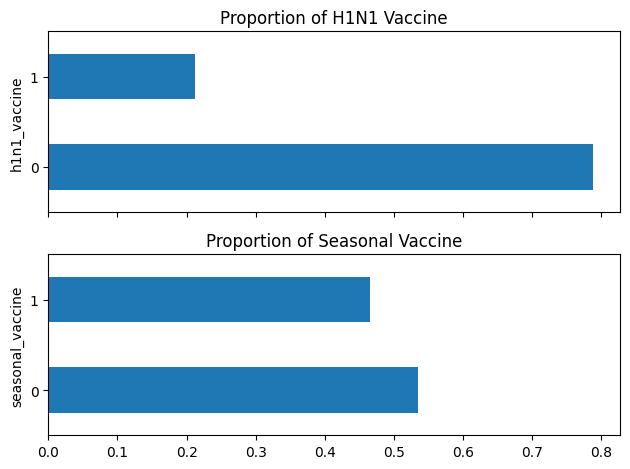

In [ ]:
# Inspect labels distribution
fig, ax = plt.subplots(2, 1, sharex=True)

n_obs = y.shape[0]

(y['h1n1_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of H1N1 Vaccine", ax=ax[0])
)
ax[0].set_ylabel("h1n1_vaccine")

(y['seasonal_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of Seasonal Vaccine", ax=ax[1])
)
ax[1].set_ylabel("seasonal_vaccine")

fig.tight_layout()

In this dataset, it looks like around half of the people received the seasonal flu vaccine whereas only around 20% of people received the H1N1 vaccine.

For h1n1_vaccine, we can see that the majority of individuals did not receive the vaccine, with only a small proportion actually receiving it. The imbalanced classes suggests a bias towards the negative class (no vaccination).

For seasonal_vaccine, the target has balanced classes, with a higher proportion of individuals receiving the vaccine compared to the h1n1_vaccine distribution.

In [ ]:
# Check for duplicates of records
print("Duplicated records: ", X.duplicated().sum())

Duplicated records:  0


In [ ]:
# Check for missing values
print("Count of missing values: ")
print(X.isnull().sum())
print(y.isnull().sum())

Count of missing values: 
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_stat

Although the values for training labels (h1n1_vaccine and seasonsal_vaccine) are complete, there are lots of missing feature values so we need to impute them.

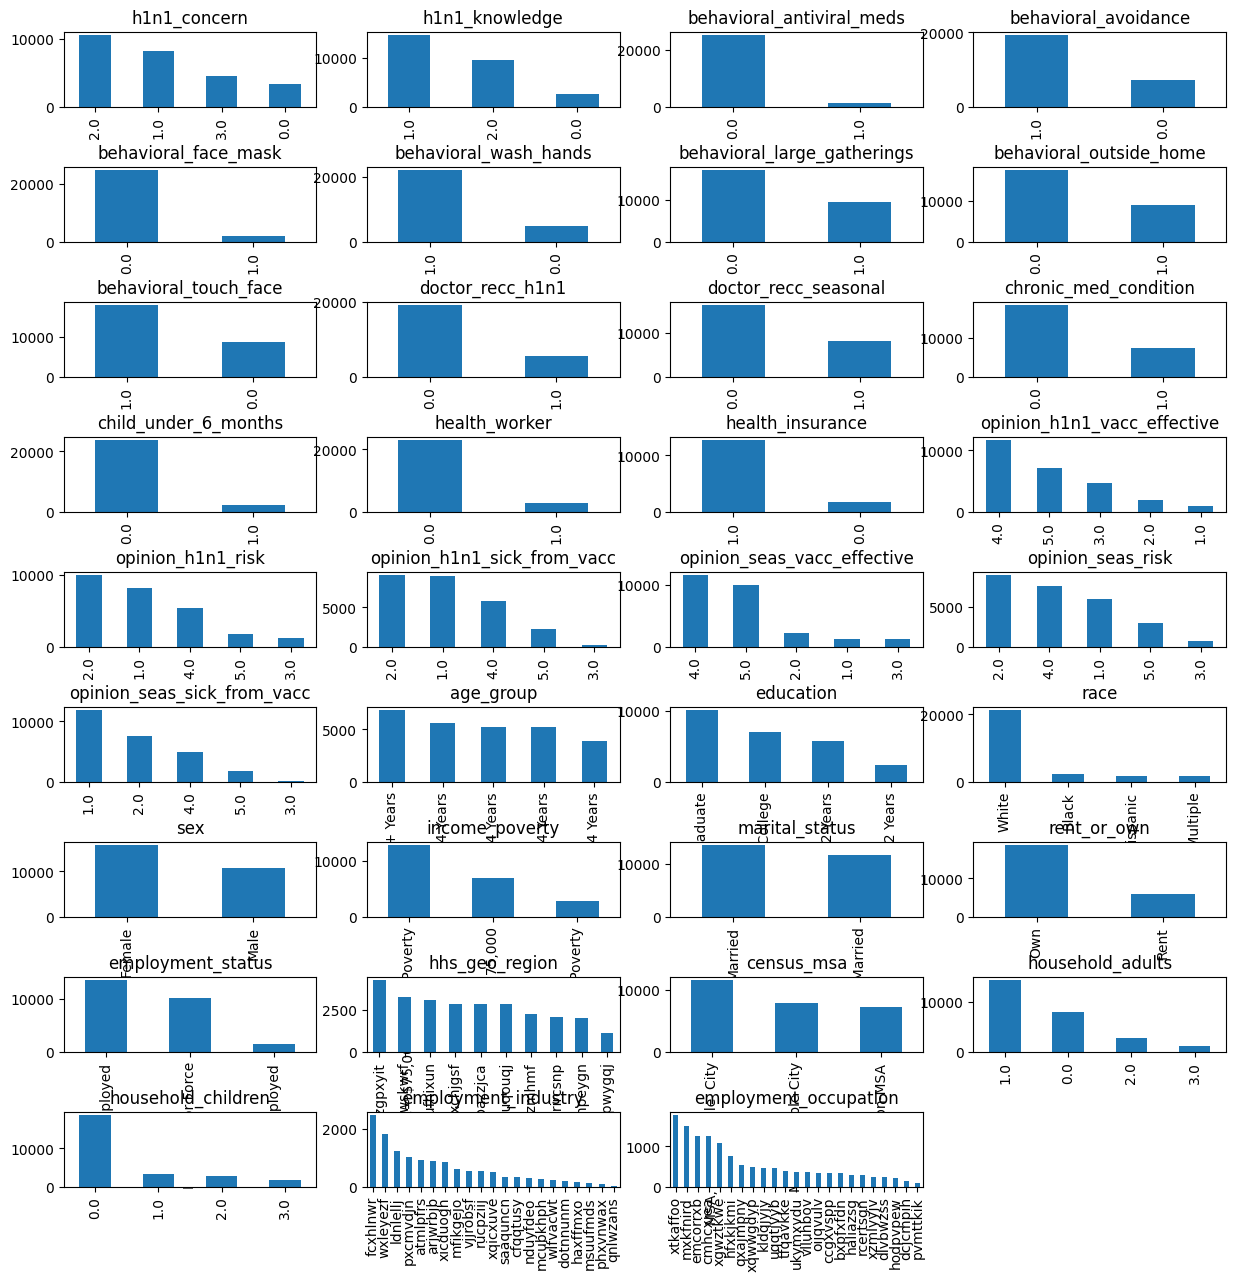

In [ ]:
# Check for outliers and distributions
# As the dataset is categorical, we examine the frequency distribution of each categorical feature
fig, axs = plt.subplots(nrows=9, ncols=4, figsize=(15, 15))
plt.subplots_adjust(hspace=0.8)

# Loop over the categorical columns and plot each one
for i, col in enumerate(X.columns):
    row, col_num = divmod(i, 4)
    ax = axs[row, col_num]
    X[col].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(col)
# Remove any unused subplots
for i in range(len(X.columns), 9*4):
    fig.delaxes(axs.flatten()[i])

plt.show()

In [ ]:
# Check if the two target variables are independent
# Phi Coefficient (Pearson) is a measure of association for two binary variables
phi_coe = y["h1n1_vaccine"].corr(y["seasonal_vaccine"])
print(f"Phi coefficient between the labels: {phi_coe:.4}")

# Cross-tabulation
pd.crosstab(
    y["h1n1_vaccine"],
    y["seasonal_vaccine"],
    margins=True,
    normalize=True
)

Phi coefficient between the labels: 0.3771


seasonal_vaccine,0,1,All
h1n1_vaccine,,,
0,0.497810,0.289737,0.787546
1,0.036582,0.175871,0.212454
All,0.534392,0.465608,1.000000


These two target variables have a phi coefficient of 0.3771, indicating a moderate positive correlation. From the cross-tabulation, it can be seen that most people who received an H1N1 flu vaccine also got the seasonal flu vaccine.

# Data Cleaning

In [ ]:
"""
Contributed by Wai Bin Cheang
"""

# Encode ordinal features
X['age_group'] = X['age_group'].map({'18 - 34 Years': 1,
                                     '35 - 44 Years': 2,
                                     '45 - 54 Years': 3,
                                     '55 - 64 Years': 4,
                                     '65+ Years': 5})
X['education'] = X['education'].map({'< 12 Years': 1,
                                     '12 Years': 2,
                                     'Some College': 3,
                                     'College Graduate': 4})
X['sex'] = X['sex'].map({'Female': 0,
                         'Male': 1})
X['income_poverty'] = X['income_poverty'].map({'Below Poverty': 1,
                                               '<= $75,000, Above Poverty': 2,
                                               '> $75,000': 3})
X['marital_status'] = X['marital_status'].map({'Not Married': 0,
                                               'Married': 1})
X['rent_or_own'] = X['rent_or_own'].map({'Own': 0,
                                         'Rent': 1})
X['census_msa'] = X['census_msa'].map({'Non-MSA': 1,
                                       'MSA, Not Principle  City': 2,
                                       'MSA, Principle City': 3})

# Seperate ordinal and nominal columns
ordinal_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
nominal_cols = [col for col in X.columns if X[col].dtype == 'object']


# Data Preprocessing

In [ ]:
# ## !!!!! For clean run only !!!!!
# X[X.select_dtypes('object').columns] = X[X.select_dtypes('object').columns].astype('string')

# # Seperate ordinal and nominal columns
# ordinal_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
# nominal_cols = [col for col in X.columns if X[col].dtype == 'string']

# # Drop all row with missing features because catboost does not accept missing value
# df = X.merge(y, on='respondent_id')
# df.dropna(axis=0, inplace=True)
# y = df[['h1n1_vaccine','seasonal_vaccine']]
# X = df.drop(['h1n1_vaccine','seasonal_vaccine'], axis=1)

# # Split train and test dataset
# X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, stratify=y,
#                                                   random_state=0)

In [ ]:
"""
Best Approach
Contributed by Wai Bin Cheang
"""

# Drop all rows of ordinal columns with missing value
df = X.merge(y, on='respondent_id')
df.dropna(axis=0, subset=ordinal_cols, inplace=True)
y = df[['h1n1_vaccine','seasonal_vaccine']]
X = df.drop(['h1n1_vaccine','seasonal_vaccine'], axis=1)

# Split train and test dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, stratify=y,
                                                  random_state=0)

# One Hot Encoding for nominal columns
# preprocessor1 = ColumnTransformer([
#     ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False), nominal_cols)
# ], remainder='passthrough')
preprocessor1 = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False), nominal_cols)
], remainder='passthrough')

# Transform the columns and put the column name back
X_train = pd.DataFrame(preprocessor1.fit_transform(X_train), columns=preprocessor1.get_feature_names_out())
X_val = pd.DataFrame(preprocessor1.transform(X_val), columns=preprocessor1.get_feature_names_out())

# Type cast to int for efficiency
X_train = X_train.astype('int')
X_val = X_val.astype('int')

# Get the categorical feature index
cat_cols = X_train.select_dtypes(include=['int']).columns
cat_col_indices = X_train.columns.get_indexer(cat_cols)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# """
# Contributed by Lik Wei Tan
# """

# df = X.merge(y, on='respondent_id')

# # Drop rows with more than 40% missing values
# threshold = len(df.columns) * 0.6
# df.dropna(thresh=threshold, axis=0, inplace=True)

# y = df[['h1n1_vaccine','seasonal_vaccine']]
# X = df.drop(['h1n1_vaccine','seasonal_vaccine'], axis=1)

# # Split train and test dataset
# X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, stratify=y,
#                                                   random_state=0)

# # Bundle preprocessing for numerical and categorical columns
# preprocessor = ColumnTransformer([
#     ('imputer', SimpleImputer(strategy='mean'), ordinal_cols),
#     ('scaler', StandardScaler(), ordinal_cols),
#     ('encoder', OneHotEncoder(handle_unknown='ignore'), nominal_cols),
# ])

# # Transform the columns and put the column name back
# X_train = pd.DataFrame(preprocessor.fit_transform(X_train), columns=preprocessor.get_feature_names_out())
# X_val = pd.DataFrame(preprocessor.transform(X_val), columns=preprocessor.get_feature_names_out())

# # Get the categorical feature index
# cat_cols = X_train.select_dtypes(include=['int']).columns
# cat_col_indices = X_train.columns.get_indexer(cat_cols)

# Feature Selection

In [ ]:
# """
# Contributed by Wai Bin Cheang
# """

# # Compute mutual information between features and target
# mi_scores_h1n1 = mutual_info_classif(X_train, y_train.iloc[:,0], n_neighbors=3, random_state=0)
# mi_scores_h1n1 = pd.Series(mi_scores_h1n1, name="MI Scores", index=X_train.columns)

# mi_scores_seasonal = mutual_info_classif(X_train, y_train.iloc[:,1], n_neighbors=3, random_state=0)
# mi_scores_seasonal = pd.Series(mi_scores_seasonal, name="MI Scores", index=X_train.columns)

# # Only drop columns where both H1N1's and Seasonal's MI agree
# mi_drop_cols = list(set(mi_scores_h1n1[mi_scores_h1n1 == 0].index).intersection(set(mi_scores_seasonal[mi_scores_seasonal == 0].index)))

# # Remove features that has 0 mutual information with target
# X_train_fe = X_train.drop(columns=mi_drop_cols)
# X_val_fe = X_val.drop(columns=mi_drop_cols)

# # Get the categorical feature index
# cat_cols = X_train_fe.select_dtypes(include=['int']).columns
# cat_col_indices = X_train_fe.columns.get_indexer(cat_cols)


In [ ]:
"""
Best Approach
Contributed by Lik Wei Tan
"""

# Use ExtraTreesClassifier for feature selection
h1n1_etc = ExtraTreesClassifier(n_estimators=100, random_state=0)
h1n1_etc.fit(X_train, y_train['h1n1_vaccine'])
seasonal_etc = ExtraTreesClassifier(n_estimators=100, random_state=0)
seasonal_etc.fit(X_train, y_train['seasonal_vaccine'])

# Get feature importances and Select top features with highest importances
h1n1_imp_scores = pd.Series(h1n1_etc.feature_importances_, index=X_train.columns)
h1n1_imp_cols = h1n1_imp_scores.nlargest(58)
seasonal_imp_scores = pd.Series(seasonal_etc.feature_importances_, index=X_train.columns)
seasonal_imp_cols = seasonal_imp_scores.nlargest(58)

# Select only the common important features
common_best_features = h1n1_imp_cols.index.intersection(seasonal_imp_cols.index)
X_train_fe = X_train[common_best_features]
X_val_fe = X_val[common_best_features]

print("\nSelected the", len(common_best_features), "most important features.")

# Get the categorical feature index
cat_cols = X_train_fe.select_dtypes(include=['int']).columns
cat_col_indices = X_train_fe.columns.get_indexer(cat_cols)


Selected the 56 most important features.


50.62830706157592

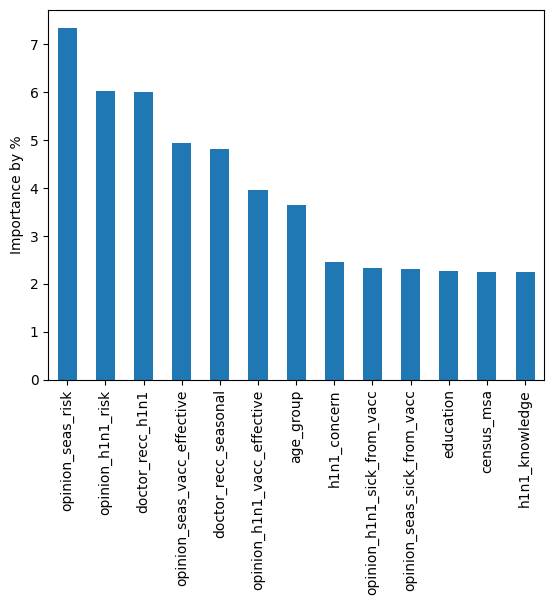

In [ ]:
selected_feature = ((seasonal_imp_cols[common_best_features] + h1n1_imp_cols[common_best_features]) / 2).sort_values(ascending=False)
selected_feature = selected_feature.rename(lambda x: x.split('__')[1])
selected_feature = selected_feature * 100
selected_feature[selected_feature > 2].plot.bar()
plt.ylabel('Importance by %')

selected_feature[selected_feature > 2].sum()

# Hyperparameter Tuning

In [ ]:
"""
Best Approach
Contributed by Wai Bin Cheang
"""

def objective_h1n1(trial):
  param = {
      'iterations': trial.suggest_int('iterations', 150, 350, step=50),
      'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, step=0.001),
      'depth': trial.suggest_int('depth', 5, 9, step=1),
      'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 15, 25, step=1),
      'random_strength': trial.suggest_float('random_strength', 0, 3, step=0.01),
      'subsample': trial.suggest_float('subsample', 0.5, 1, step=0.01),
      'cat_features': cat_col_indices,
      'eval_metric': "AUC",
      'silent': True,
      'random_state': 0
  }

  fit_param = {
      'early_stopping_rounds': 5,
  }

  model = MultiOutputClassifier(CatBoostClassifier(**param))

  score = cross_val_score(model, X_train_fe, y_train, cv=5, scoring='roc_auc',
                          fit_params=fit_param, n_jobs=-1).mean()

  return score

study_h1n1 = optuna.create_study(direction='maximize', pruner=optuna.pruners.HyperbandPruner())
study_h1n1.optimize(objective_h1n1, n_trials=100)
print(study_h1n1.best_trial.value)
print(study_h1n1.best_trial.params)

[I 2023-03-28 12:33:16,037] A new study created in memory with name: no-name-b131eee5-428b-487b-a7bc-05dabf1ecd52
[I 2023-03-28 12:33:29,682] Trial 0 finished with value: 0.8709894354514163 and parameters: {'iterations': 200, 'learning_rate': 0.137, 'depth': 7, 'l2_leaf_reg': 20, 'random_strength': 0.02, 'subsample': 0.91}. Best is trial 0 with value: 0.8709894354514163.
[I 2023-03-28 12:33:38,719] Trial 1 finished with value: 0.8640361858971328 and parameters: {'iterations': 250, 'learning_rate': 0.011, 'depth': 5, 'l2_leaf_reg': 19, 'random_strength': 1.12, 'subsample': 0.87}. Best is trial 0 with value: 0.8709894354514163.
[I 2023-03-28 12:33:42,368] Trial 2 finished with value: 0.8702511346966977 and parameters: {'iterations': 150, 'learning_rate': 0.049, 'depth': 5, 'l2_leaf_reg': 23, 'random_strength': 0.39, 'subsample': 0.9299999999999999}. Best is trial 0 with value: 0.8709894354514163.
[I 2023-03-28 12:33:51,024] Trial 3 finished with value: 0.8722012586169056 and parameters: 

0.8732462027761384
{'iterations': 350, 'learning_rate': 0.051000000000000004, 'depth': 6, 'l2_leaf_reg': 16, 'random_strength': 0.52, 'subsample': 0.6}


0.8732462027761384 (multi)
{'iterations': 350, 'learning_rate': 0.051000000000000004, 'depth': 6, 'l2_leaf_reg': 16, 'random_strength': 0.52, 'subsample': 0.6}


In [ ]:
optuna.visualization.plot_param_importances(study_h1n1).show(renderer="browser")

In [ ]:
optuna.visualization.plot_slice(study_h1n1).show(renderer="browser")

# Modelling and Testing

In [ ]:
# ## !!!!! For clean run only !!!!!
# model_cb = MultiOutputClassifier(CatBoostClassifier(iterations=100, cat_features=nominal_cols, silent=True, random_state=0))
# score_cb = cross_val_score(model_cb, X_train, y_train, scoring='roc_auc', cv=5).mean()
# print(f"CatBoost's ROC AUC score: {score_cb:.2%}")


CatBoost's ROC AUC score: 86.59%


In [ ]:
# """
# Contributed by Wai Bin Cheang
# with Preprocessing
# """
# model_cb = MultiOutputClassifier(CatBoostClassifier(iterations=100, cat_features=cat_col_indices, silent=True, random_state=0))
# score_cb = cross_val_score(model_cb, X_train, y_train, scoring='roc_auc', cv=5).mean()
# print(f"CatBoost's ROC AUC score: {score_cb:.2%}")

CatBoost's ROC AUC score: 86.87%


In [ ]:
# """
# Contributed by Lik Wei Tan
# with Preprocessing
# """
# model_cb = MultiOutputClassifier(CatBoostClassifier(iterations=100, cat_features=cat_col_indices, silent=True, random_state=0))
# score_cb = cross_val_score(model_cb, X_train, y_train, scoring='roc_auc', cv=5).mean()
# print(f"CatBoost's ROC AUC score: {score_cb:.2%}")

CatBoost's ROC AUC score: 86.51%


In [ ]:
# """
# Contributed by Wai Bin Cheang
# with Preprocessing and Feature Engineering
# """
# model_cb = MultiOutputClassifier(CatBoostClassifier(iterations=100, cat_features=cat_col_indices, silent=True, random_state=0))
# score_cb = cross_val_score(model_cb, X_train_fe, y_train, scoring='roc_auc', cv=5).mean()
# print(f"CatBoost's ROC AUC score: {score_cb:.2%}")

CatBoost's ROC AUC score: 86.92%


In [ ]:
# """
# Contributed by Lik Wei Tan
# with Preprocessing and Feature Engineering
# """
# model_cb = MultiOutputClassifier(CatBoostClassifier(iterations=100, cat_features=cat_col_indices, silent=True, random_state=0))
# score_cb = cross_val_score(model_cb, X_train_fe, y_train, scoring='roc_auc', cv=5).mean()
# print(f"CatBoost's ROC AUC score: {score_cb:.2%}")

CatBoost's ROC AUC score: 87.02%


In [ ]:
"""
Contributed by Wai Bin Cheang
with Preprocessing, Feature Engineering, and Hyperparameter Tuning
"""
# Tuned result from Optuna
param = {
    'iterations': 350,
    'learning_rate': 0.051,
    'depth': 6,
    'l2_leaf_reg': 16,
    'random_strength': 0.52,
    'subsample': 0.6,
    'cat_features': cat_col_indices,
    'eval_metric': "AUC",
    'silent': True,
    'random_state': 0
  }

fit_param = {
    'early_stopping_rounds': 5,
}

# Train multi classifier
model_cb = MultiOutputClassifier(CatBoostClassifier(**param))
score_cb = cross_val_score(model_cb, X_train_fe, y_train, cv=5, scoring='roc_auc',
                          fit_params=fit_param, n_jobs=-1).mean()
print(f"CatBoost's ROC AUC score (using multi tuned HP): {score_cb:.2%}")


CatBoost's ROC AUC score (using multi tuned HP): 87.28%


In [ ]:
# """
# Contributed by Lik Wei Tan
# with Preprocessing, Feature Engineering, and Hyperparameter Tuning
# """

# from sklearn.model_selection import RandomizedSearchCV

# # Define the hyperparameter grid
# param_dist = {'estimator__depth': [2, 4, 6],
#               'estimator__learning_rate': [0.1, 0.15, 0.2],
#               'estimator__l2_leaf_reg': [2, 4, 6],
# }

# # Define the CatBoost model as a MultiOutputClassifier
# model_cb = MultiOutputClassifier(CatBoostClassifier(iterations=200, cat_features=cat_col_indices, random_state=18, early_stopping_rounds=5))
# # Define a RandomizedSearchCV object with the CatBoost model, hyperparameter grid, 5-fold cross-validation
# random_search = RandomizedSearchCV(model_cb, param_distributions=param_dist, cv=5, n_jobs=-1, random_state=18, scoring='roc_auc')

# # Compute the cross-validated ROC AUC score for the CatBoost model with the optimized hyperparameters
# score_cb = cross_val_score(random_search, X_train_fe, y_train, scoring='roc_auc', cv=5).mean()
# print(f"CatBoost's ROC AUC score from cross-validation: {score_cb:.2%}")

0:	learn: 0.6458006	total: 64.6ms	remaining: 12.9s
1:	learn: 0.6088233	total: 75.5ms	remaining: 7.47s
2:	learn: 0.5801693	total: 87.9ms	remaining: 5.77s
3:	learn: 0.5573311	total: 98.9ms	remaining: 4.84s
4:	learn: 0.5341067	total: 110ms	remaining: 4.29s
5:	learn: 0.5168660	total: 123ms	remaining: 3.98s
6:	learn: 0.5030572	total: 135ms	remaining: 3.73s
7:	learn: 0.4921406	total: 147ms	remaining: 3.52s
8:	learn: 0.4852556	total: 160ms	remaining: 3.4s
9:	learn: 0.4776694	total: 174ms	remaining: 3.3s
10:	learn: 0.4715001	total: 183ms	remaining: 3.14s
11:	learn: 0.4654993	total: 191ms	remaining: 3s
12:	learn: 0.4597661	total: 206ms	remaining: 2.96s
13:	learn: 0.4550883	total: 218ms	remaining: 2.9s
14:	learn: 0.4505621	total: 231ms	remaining: 2.85s
15:	learn: 0.4471985	total: 244ms	remaining: 2.81s
16:	learn: 0.4442209	total: 258ms	remaining: 2.77s
17:	learn: 0.4411373	total: 280ms	remaining: 2.83s
18:	learn: 0.4388491	total: 292ms	remaining: 2.78s
19:	learn: 0.4361798	total: 307ms	remaining

# Model Submission

In [ ]:
# Load the data
X = pd.read_csv('./training_set_features.csv', encoding='utf8', index_col=0)
y = pd.read_csv('./training_set_labels.csv', encoding='utf8', index_col=0)
X_test = pd.read_csv('./test_set_features.csv', encoding='utf8', index_col=0)

# Encode ordinal features
X['age_group'] = X['age_group'].map({'18 - 34 Years': 1,
                                     '35 - 44 Years': 2,
                                     '45 - 54 Years': 3,
                                     '55 - 64 Years': 4,
                                     '65+ Years': 5})
X['education'] = X['education'].map({'< 12 Years': 1,
                                     '12 Years': 2,
                                     'Some College': 3,
                                     'College Graduate': 4})
X['sex'] = X['sex'].map({'Female': 0,
                         'Male': 1})
X['income_poverty'] = X['income_poverty'].map({'Below Poverty': 1,
                                               '<= $75,000, Above Poverty': 2,
                                               '> $75,000': 3})
X['marital_status'] = X['marital_status'].map({'Not Married': 0,
                                               'Married': 1})
X['rent_or_own'] = X['rent_or_own'].map({'Own': 0,
                                         'Rent': 1})
X['census_msa'] = X['census_msa'].map({'Non-MSA': 1,
                                       'MSA, Not Principle  City': 2,
                                       'MSA, Principle City': 3})

X_test['age_group'] = X_test['age_group'].map({'18 - 34 Years': 1,
                                     '35 - 44 Years': 2,
                                     '45 - 54 Years': 3,
                                     '55 - 64 Years': 4,
                                     '65+ Years': 5})
X_test['education'] = X_test['education'].map({'< 12 Years': 1,
                                     '12 Years': 2,
                                     'Some College': 3,
                                     'College Graduate': 4})
X_test['sex'] = X_test['sex'].map({'Female': 0,
                         'Male': 1})
X_test['income_poverty'] = X_test['income_poverty'].map({'Below Poverty': 1,
                                               '<= $75,000, Above Poverty': 2,
                                               '> $75,000': 3})
X_test['marital_status'] = X_test['marital_status'].map({'Not Married': 0,
                                               'Married': 1})
X_test['rent_or_own'] = X_test['rent_or_own'].map({'Own': 0,
                                         'Rent': 1})
X_test['census_msa'] = X_test['census_msa'].map({'Non-MSA': 1,
                                       'MSA, Not Principle  City': 2,
                                       'MSA, Principle City': 3})

# Seperate ordinal and nominal columns
ordinal_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
nominal_cols = [col for col in X.columns if X[col].dtype == 'object']

# Drop all rows of ordinal columns with missing value
df = X.merge(y, on='respondent_id')
df.dropna(axis=0, subset=ordinal_cols, inplace=True)
y = df[['h1n1_vaccine','seasonal_vaccine']]
X = df.drop(['h1n1_vaccine','seasonal_vaccine'], axis=1)
# X_test.dropna(axis=0, subset=ordinal_cols, inplace=True)

preprocessor1 = ColumnTransformer([
    ('imputer', SimpleImputer(strategy='most_frequent'), ordinal_cols),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False), nominal_cols)
], remainder='passthrough')

# # Transform the columns and put the column name back
X_train = pd.DataFrame(preprocessor1.fit_transform(X), columns=preprocessor1.get_feature_names_out())
X_test = pd.DataFrame(preprocessor1.transform(X_test), columns=preprocessor1.get_feature_names_out(), index=X_test.index)

# # Type cast to int for efficiency
X_train = X_train.astype('int')
X_test = X_test.astype('int')

# Use ExtraTreesClassifier for feature selection
h1n1_etc = ExtraTreesClassifier(n_estimators=100, random_state=0)
h1n1_etc.fit(X_train, y['h1n1_vaccine'])
seasonal_etc = ExtraTreesClassifier(n_estimators=100, random_state=0)
seasonal_etc.fit(X_train, y['seasonal_vaccine'])

# Get feature importances and Select top features with highest importances
h1n1_imp_scores = pd.Series(h1n1_etc.feature_importances_, index=X_train.columns)
h1n1_imp_cols = h1n1_imp_scores.nlargest(58)
seasonal_imp_scores = pd.Series(seasonal_etc.feature_importances_, index=X_train.columns)
seasonal_imp_cols = seasonal_imp_scores.nlargest(58)

# Select only the common important features
common_best_features = h1n1_imp_cols.index.intersection(seasonal_imp_cols.index)
X_train_fe = X_train[common_best_features]
X_test_fe = X_test[common_best_features]

print("\nSelected the", len(common_best_features), "most important features.")

# Get the categorical feature index
cat_cols = X_train_fe.select_dtypes(include=['int']).columns
cat_col_indices = X_train_fe.columns.get_indexer(cat_cols)


# Tuned result from Optuna
param = {
    'iterations': 350,
    'learning_rate': 0.051,
    'depth': 6,
    'l2_leaf_reg': 16,
    'random_strength': 0.52,
    'subsample': 0.6,
    'cat_features': cat_col_indices,
    'eval_metric': "AUC",
    'silent': True,
    'random_state': 0
  }

fit_param = {
    'early_stopping_rounds': 5,
}

# Train multi classifier
model_cb = MultiOutputClassifier(CatBoostClassifier(**param))
model_cb.fit(X_train, y)

test_probas = model_cb.predict_proba(X_test)
test_probas

submission_df = pd.read_csv("./submission_format.csv", index_col="respondent_id")

import numpy as np
# Make sure we have the rows in the same order
np.testing.assert_array_equal(X_test.index.values, submission_df.index.values)

# Save predictions to submission data frame
submission_df["h1n1_vaccine"] = test_probas[0][:, 1]
submission_df["seasonal_vaccine"] = test_probas[1][:, 1]

submission_df.head()

submission_df.to_csv('my_submission.csv', index=True)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



Selected the 56 most important features.


In [ ]:
submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.142932,0.192803
26708,0.019075,0.031648
26709,0.761251,0.880843
26710,0.582820,0.893041
26711,0.237263,0.447973
